In [7]:
from artificial_experiments_alter import NoisyProbClassifier
from artificial_experiments_fisher import PerfectProbClassifier
import numpy as np

noisy = NoisyProbClassifier()
perfect = PerfectProbClassifier(mu1=-1,std1=1,mu2=1,std2=1)

x = np.array([-3., -1., 0., 1., 3.])
print(perfect.predict_proba(x))
print(noisy.predict_proba(x))


[[0.99752738 0.00247262]
 [0.88079708 0.11920292]
 [0.5        0.5       ]
 [0.11920292 0.88079708]
 [0.00247262 0.99752738]]
[[0.99752738 0.00247262]
 [0.88079708 0.11920292]
 [0.5        0.5       ]
 [0.11920292 0.88079708]
 [0.00247262 0.99752738]]


{'epsilon_smoothing': (0, 1e-06, 1e-05, 0.0001, 0.001, 0.01)}
{'tau': (0.25, 0.5, 0.75, 1.0, 1.25, 1.5, 2.0, 3.0, 5.0)}
{'lambd': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ])}
{'eta': (0.0, 0.0001, 0.001)}
{'alpha': (1.0, 2.0, 5.0, 10.0)}
{'kappa': (0.3, 0.5, 0.8, 1)}


/tmp/ipykernel_4189039/2498544208.py:100: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0,0,0.9,1])


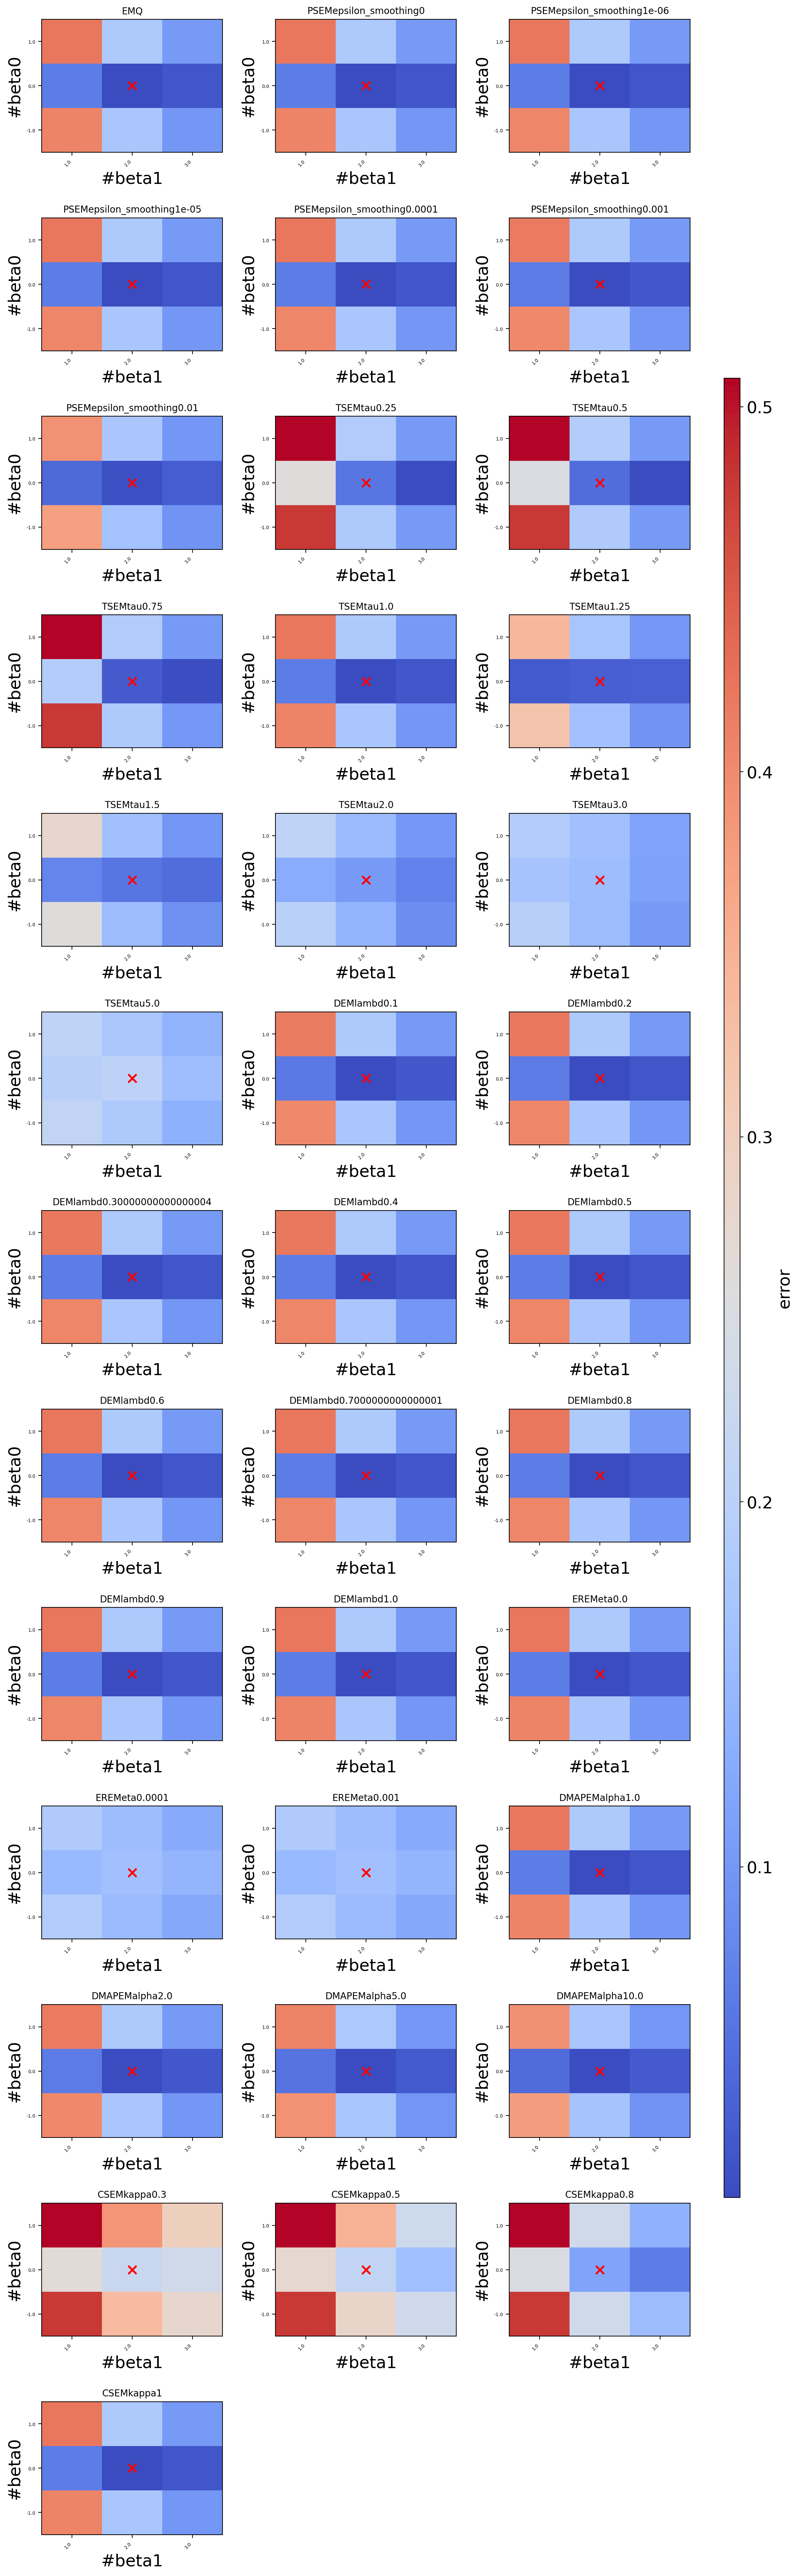

(<Figure size 2400x7800 with 38 Axes>,
 array([<Axes: title={'center': 'EMQ'}, xlabel='#beta1', ylabel='#beta0'>,
        <Axes: title={'center': 'PSEMepsilon_smoothing0'}, xlabel='#beta1', ylabel='#beta0'>,
        <Axes: title={'center': 'PSEMepsilon_smoothing1e-06'}, xlabel='#beta1', ylabel='#beta0'>,
        <Axes: title={'center': 'PSEMepsilon_smoothing1e-05'}, xlabel='#beta1', ylabel='#beta0'>,
        <Axes: title={'center': 'PSEMepsilon_smoothing0.0001'}, xlabel='#beta1', ylabel='#beta0'>,
        <Axes: title={'center': 'PSEMepsilon_smoothing0.001'}, xlabel='#beta1', ylabel='#beta0'>,
        <Axes: title={'center': 'PSEMepsilon_smoothing0.01'}, xlabel='#beta1', ylabel='#beta0'>,
        <Axes: title={'center': 'TSEMtau0.25'}, xlabel='#beta1', ylabel='#beta0'>,
        <Axes: title={'center': 'TSEMtau0.5'}, xlabel='#beta1', ylabel='#beta0'>,
        <Axes: title={'center': 'TSEMtau0.75'}, xlabel='#beta1', ylabel='#beta0'>,
        <Axes: title={'center': 'TSEMtau1.0'}, xlabel=

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from math import ceil

def plot_beta_heatmaps(df, method_cols=None, beta0_col='#beta0', beta1_col='#beta1',
                       ncols=3, cmap='viridis', annotate=False, mark_ideal=(0.0, 2.0),
                       figsize_per_plot=(4,3), vmin=None, vmax=None, suptitle=None):
    """
    Dibuja un heatmap por cada columna método en method_cols mostrando el valor
    (error) sobre la grilla (beta0, beta1).

    - df: DataFrame con columnas beta0, beta1 y columnas para cada método (errores).
    - method_cols: lista de columnas a representar. Si None toma todas las columnas
                   excepto beta0_col y beta1_col.
    - annotate: si True escribe el valor numérico dentro de cada celda (puede estar
                saturado/feo si hay muchas celdas).
    - mark_ideal: tupla (beta0, beta1) marcada con una cruz en cada heatmap.
    - vmin/vmax: rango del colorbar. Si None se calcula globalmente (recomendado).
    - figsize_per_plot: (w,h) por subplot.
    - ncols: número de columnas en la figura (layout).
    - cmap: colormap matplotlib.
    - suptitle: título global opcional.
    """
    # elegir columnas de método
    if method_cols is None:
        method_cols = [c for c in df.columns if c not in (beta0_col, beta1_col)]
        method_cols = sorted(method_cols)

    # valores únicos y ordenados de los betas (asegura orden consistente)
    beta0_vals = np.sort(df[beta0_col].unique())
    beta1_vals = np.sort(df[beta1_col].unique())

    n_methods = len(method_cols)
    nrows = ceil(n_methods / ncols)
    fig_w = ncols * figsize_per_plot[0]
    fig_h = nrows * figsize_per_plot[1]

    # construir matrices para cada método usando pivot (beta0 -> rows, beta1 -> cols)
    mats = {}
    for m in method_cols:
        pivot = df.pivot_table(index=beta0_col, columns=beta1_col, values=m, aggfunc='mean')
        # reindex para garantizar orden y que filas/cols faltantes se llenen con nan
        pivot = pivot.reindex(index=beta0_vals, columns=beta1_vals)
        mats[m] = pivot.values

    # calcular vmin/vmax global si no proporcionado (para escala consistente)
    if vmin is None:
        vmin = np.nanmin([np.nanmin(v) for v in mats.values()])
    if vmax is None:
        vmax = np.nanmax([np.nanmax(v) for v in mats.values()])

    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(fig_w, fig_h), squeeze=False)
    axes = axes.flatten()

    for i, m in enumerate(method_cols):
        ax = axes[i]
        mat = mats[m]
        im = ax.imshow(mat, origin='lower', aspect='auto', vmin=vmin, vmax=vmax, cmap=cmap)

        # ticks -> mostrar los valores reales de beta1 y beta0 (puede saturar si hay muchos)
        ax.set_xticks(np.arange(len(beta1_vals)))
        ax.set_xticklabels([str(x) for x in beta1_vals], rotation=45, ha='right', fontsize=5)
        ax.set_yticks(np.arange(len(beta0_vals)))
        ax.set_yticklabels([str(x) for x in beta0_vals], fontsize=5)
        ax.set_xlabel('#beta1')
        ax.set_ylabel('#beta0')
        ax.set_title(m,fontsize=10)

        # anotar celdas si se quiere (cuidado con performance/legibilidad)
        if annotate:
            for (r, c), val in np.ndenumerate(mat):
                if not np.isnan(val):
                    ax.text(c, r, f"{val:.3f}", ha='center', va='center', fontsize=7, color='white' if (val - vmin) / (vmax - vmin + 1e-12) > 0.5 else 'black')

        # marcar punto ideal si existe en los ejes
        try:
            b0_idx = int(np.where(beta0_vals == mark_ideal[0])[0][0])
            b1_idx = int(np.where(beta1_vals == mark_ideal[1])[0][0])
            ax.scatter([b1_idx], [b0_idx], marker='x', s=80, c='red', linewidths=2)
        except Exception:
            # si la pareja ideal no está en la grilla, intentamos aproximarla por nearest
            # (opcional): comentar si prefieres no marcar nada
            if mark_ideal is not None:
                b0_idx = np.abs(beta0_vals - mark_ideal[0]).argmin()
                b1_idx = np.abs(beta1_vals - mark_ideal[1]).argmin()
                ax.scatter([b1_idx], [b0_idx], marker='x', s=50, c='red', linewidths=1)

    # borrar ejes sobrantes
    for j in range(n_methods, len(axes)):
        fig.delaxes(axes[j])

    # colorbar común
    cax = fig.add_axes([0.92, 0.15, 0.02, 0.7])  # derecha
    fig.colorbar(im, cax=cax, label='error')

    if suptitle:
        fig.suptitle(suptitle)

    plt.tight_layout(rect=[0,0,0.9,1])
    plt.show()
    return fig, axes

from run_experiments_v2 import get_heuristic_parameters
heuristics = {'PSEM':"EMQPosteriorSmoothing",'TSEM':'EMQTempScaling','DEM':'EMQDamping','EREM':'EMQEntropyReg','DMAPEM':'EMQDirichletMAP','CSEM':'EMQConfidentSubset'}
methods_names = ['EMQ']
if len(heuristics)>0:
    for heuristic,c in heuristics.items():
        hiperparam_values = get_heuristic_parameters(heuristic)
        print(hiperparam_values)
        hiper_name,hiper_values = next(iter(hiperparam_values.items()))
        for hiper_value in hiper_values:
            methods_names.append(heuristic+hiper_name+str(hiper_value))


df = pd.read_csv('results/artificial/maeAlter.csv')
plot_beta_heatmaps(df, method_cols=methods_names,
                   ncols=3, annotate=False, mark_ideal=(0.0, 2.0),
                   figsize_per_plot=(4,3), cmap='coolwarm')
